In [328]:
import matplotlib.pyplot as plt
from dataclasses import dataclass
from utils import make_table

In [329]:
@dataclass
class Item:
    valor: int
    peso: int
    is_otimo: bool

    @property
    def custo_beneficio(self):
        return self.valor / self.peso

sizes = [100, 200, 500, 1000, 2000, 5000, 10000]

BeneficioMaximo = int

Capacidade = int


def get_data(cat: int, size: int) -> tuple[BeneficioMaximo, Capacidade, list[Item]]:
    path = "dataset/{}/knapPI_{}_{}_1000_1"

    with open(path.format("large_scale", cat, size), "r") as f:
        get_line_values = lambda: list(map(int, f.readline().split()))
        # Pega o resultado ótimo
        with open(path.format("large_scale-optimum", cat, size), "r") as g:
            beneficio_maximo = int(g.read())

        # Primeira Linha: número de itens `n`e capacidade da mochila
        n, capacidade = get_line_values()

        # Próximas `n`linhas: valor e peso de cada item
        valores, pesos = [list(i) for i in zip(*[get_line_values() for _ in range(n)])]

        # Última linha: vetor de booleanos indicando quais itens compõe uma solução ótima
        solucoes_otimas = get_line_values()

        itens = [
            Item(v, p, bool(otimo))
            for v, p, otimo in zip(valores, pesos, solucoes_otimas)
        ]

    return beneficio_maximo, capacidade, itens


### Analise do dataset

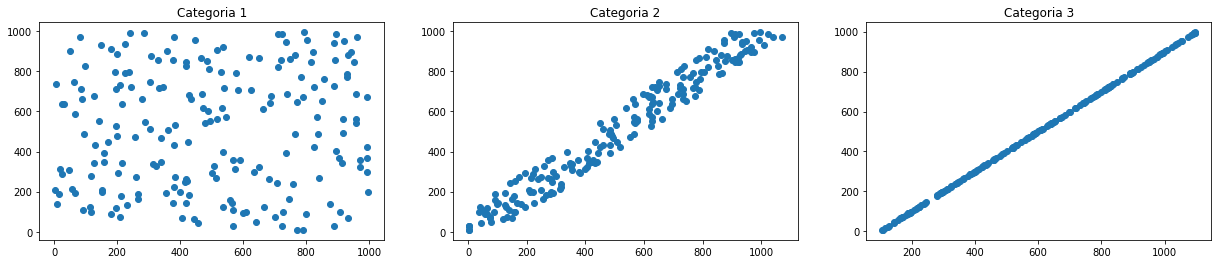

In [331]:
fig, ax = plt.subplots(1, 3, figsize=(21, 4))

for cat in [1, 2, 3]:
    itens = get_data(cat, sizes[1])[2]
    
    valores = [i.valor for i in itens]
    pesos = [i.peso for i in itens]
    
    ax[cat - 1].scatter(valores, pesos)
    ax[cat - 1].set_title(f"Categoria {cat}")

### Abordagem Gulosa

##### Priorizando o número de items a serem inseridos

In [326]:
res = {}
for cat in [1, 2, 3]:
    desempenho = []
    for size in sizes:
        beneficio_maximo, capacidade, itens = get_data(cat, size)

        v, w = 0, 0

        for item in sorted(itens, key=lambda i: i.peso):
            if (w + item.peso) > capacidade:
                break
            w += item.peso
            v += item.valor

        desempenho = round(v / beneficio_maximo, 5)
        res.setdefault(size, []).append(desempenho)

make_table(res)

╒═════════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╕
│             │   100   │   200   │   500   │  1000   │  2000   │  5000   │  10000  │
╞═════════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╡
│ Categoria 1 │ 0.95037 │ 0.95604 │ 0.87282 │ 0.8719  │ 0.88367 │ 0.88809 │ 0.87899 │
├─────────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ Categoria 2 │ 0.56935 │ 0.63831 │ 0.68003 │ 0.67963 │ 0.66323 │ 0.63081 │ 0.65429 │
├─────────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ Categoria 3 │ 0.99082 │ 0.9822  │ 0.99733 │ 0.99889 │ 0.99682 │ 0.99919 │ 0.99979 │
╘═════════════╧═════════╧═════════╧═════════╧═════════╧═════════╧═════════╧═════════╛


##### Priorizando os itens de melhor relação de benefício/custo

In [325]:
def perf_aprox_gulosa_beneficio_custo(categoria, size):
    beneficio_maximo, capacidade, itens = get_data(categoria, size)

    v, w = 0, 0
    for item in sorted(itens, key=lambda i: i.valor / i.peso, reverse=True):
        if (w + item.peso) < capacidade:
            w += item.peso
            v += item.valor

    desempenho = v / beneficio_maximo
    return desempenho


from time import time


def fazer_testes(funcao, repeticoes):
    res = {}
    tempos = {}

    for i in range(repeticoes):
        for cat in [1, 2, 3]:
            for size in [100, 200, 500, 1000, 2000, 5000, 10000]:
                start = time()
                desempenho = funcao(cat, size)
                end = time()

                if i == 0:
                    res.setdefault(size, []).append(desempenho)

                # Guarda o tempo de execução dos 3 maiores sample sizes para cada categoria
                if size in sizes[::-1][:3]:
                    t = end - start

                    tempos.setdefault(size, [0, 0, 0])
                    tempos[size][cat - 1] = t

    for ts in tempos.values():
        for t in ts:
            t = t / repeticoes

    # make_table(tempos)
    make_table(res)


fazer_testes(perf_aprox_gulosa_beneficio_custo, repeticoes=4)
from tabulate import tabulate

# print(tabulate(tempo_exec, headers="keys", tablefmt="fancy_grid"))
# print(tempo_exec)


# print("Desempenho da aproximação usando o método guloso")
# make_table(res)


╒═════════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╕
│             │   100    │   200    │   500    │   1000   │   2000   │   5000   │  10000   │
╞═════════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╡
│ Categoria 1 │ 0.963923 │ 0.999021 │ 0.999203 │ 0.997853 │ 0.999295 │ 0.999718 │ 0.999925 │
├─────────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ Categoria 2 │ 0.982166 │ 0.98164  │ 0.996934 │ 0.999337 │ 0.99928  │ 0.999865 │ 0.999945 │
├─────────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ Categoria 3 │ 0.990822 │ 0.982202 │ 0.99733  │ 0.998888 │ 0.996819 │ 0.999186 │ 0.999789 │
╘═════════════╧══════════╧══════════╧══════════╧══════════╧══════════╧══════════╧══════════╛


### Abordagem por Programação Dinâmica

In [311]:
beneficio_maximo, W, itens = get_data(1, sizes[4])

# array que guarda os resultados ótimos para mochilas de capacidade indo de 0 a W
mochilas = [0 for _ in range(W + 1)]

for item in itens:
    # index do peso das mochilas anteriores que cabem na mochila
    w_validos = [w for w in range(W) if item.peso + w <= W]

    for w in w_validos:
        mochilas[w] = max(mochilas[w], mochilas[w + item.peso] + item.valor)
